<a href="https://colab.research.google.com/github/Sirfowahid/Bangla_Contextual_Analysis/blob/main/Aspect_Based_Contextual_Analysis_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import datasets
import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
df = pd.read_excel('/content/drive/MyDrive/Projects/02. Contextual Analysis With Book Review Dataset/Book Review Aspect final.xlsx')
df.head()

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
0,89,নামাজ আদায়ের সঠিক পদ্ধতি,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,সালাত/নামায,2,কিছু পৃষ্ঠা ফাঁকা,Rokomari,negative,0,NaN,0
1,1,ছহীহ নূরানী বাংলা উচ্চারণ সহজ সরল বঙ্গানুবাদ ও...,মাওলানা ফরিদ উদ্দিন আহাম্মদ (অনুবাদক),নূরানী কুরআন,1,প্রত্যাশার নীচে কাগজের গুণমান,Rokomari,negative,0,NaN,0
2,195,ইসলামের দৃষ্টিতে পর্দার হুকুম ও নারীর মর্যাদা ...,حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,পর্দা বিধান,1,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,Rokomari,negative,0,NaN,0
3,343,আশরাফ আলি থানভির প্রিয়গল্প-২ (হার্ডকভার),حكيم الامت مولانا اشرف علي تهانوي رح ( হাকীমুল...,ইসলামি গল্প,1,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...",Rokomari,negative,0,NaN,0
4,465,ছড়ায় ছন্দে চিড়িয়াখানা (প্রাণী) (হার্ডকভার) ছো...,ইয়াছিন আরাফাত,বয়স যখন ৪-৮: বাংলা ছড়া,2,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...",Rokomari,negative,0,NaN,0


In [6]:
df.columns

Index(['id', 'Name', 'Writer_Name', 'Category', 'Rating', 'Review', 'Site',
       'sentiment', 'label', 'Comment About', 'Unnamed: 10'],
      dtype='object')

In [7]:
df.tail(10)

,id,Name,Writer_Name,Category,Rating,Review,Site,sentiment,label,Comment About,Unnamed: 10
2044,38668,সোফির জগৎ (হার্ডকভার) আন্তর্জাতিক পুরস্কার প...,ইয়স্তেন গার্ডার,পাশ্চাত্য দর্শন,3,ভালো,Rokomari,neutral,1,NaN,1
2045,38686,সোফির জগৎ (হার্ডকভার) পাশ্চাত্য দর্শনের সংক্ষ...,ইয়স্তেন গার্ডার,অনুবাদ উপন্যাস,3,ভালো,Rokomari,neutral,1,NaN,1
2046,38760,আরজ আলীর রম্য (হার্ডকভার),ইয়াছির মিশুক,ব্যঙ্গ ও রম্যরচনা,3,আমি বইটা কিনার সময় প্রথমে ভেবেছিলাম এটা প্যারা...,Rokomari,neutral,1,NaN,1
2047,38806,জেমস বন্ড সমগ্র (হার্ডকভার),ইয়ান ফ্লেমিং,"রহস্য, গোয়েন্দা, ভৌতিক, মিথ, থ্রিলার, ও অ্যাড...",3,সুন্দর বই,Rokomari,neutral,1,NaN,1
2048,38887,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,যতটা আশা নিয়ে বইটি কিনেছিলাম আসলেই সেটা সে রকম...,Rokomari,neutral,1,NaN,1
2049,38891,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,এই বইগুলি ভাল।,Rokomari,neutral,1,NaN,1
2050,38892,পাইথন প্রোগ্রামিং ল্যাংগুয়েজ ৩ (হার্ডকভার),ইয়াসির আরাফাত রাতুল,পাইথন প্রোগ্রামিং,3,ভাল,Rokomari,neutral,1,NaN,1
2051,38906,নিলামে পাঁচটি শব্দ,ইয়াসির মনন,সমকালীন গল্প,3,ছোটগল্প! আকারে ছোট। গল্প বিস্তার কম...কথা সহজ ...,Rokomari,neutral,1,NaN,1
2052,38979,Dipu Number Two (Hardcover),Muhammod Zafar Iqbal,Novel: Children and Teens,3,বইটির প্রধান চরিত্র দিপু। সবাই তাকে চেনে দিপু ...,Rokomari,neutral,1,NaN,1
2053,38988,"মাইন্ড ওয়ারস (পেপারব্যাক) সরকার, মিডিয়া ও গো...",ম্যারি ডি. জনস,"ডিটেকটিভ, ইন্টেলিজেন্স ও সিক্রেট এজেন্সি",3,অনুবাদ যথেষ্ট ভাল না।,Rokomari,neutral,1,NaN,1


In [8]:
df_mod = df[['Review','label']].dropna()

In [9]:
df_mod.describe()

,Review,label
count,2054,2054
unique,1604,4
top,ভাল,0
freq,87,1123


In [10]:
df_mod.label.unique()

array([0, 2, 1, '  '], dtype=object)

In [11]:
df_mod[df['label']=='  ']

,Review,label
634,ঠিক আছে,


In [12]:
df_mod.drop(index=634,inplace=True)

In [13]:
df_mod.label.unique()

array([0, 2, 1], dtype=object)

<Axes: >

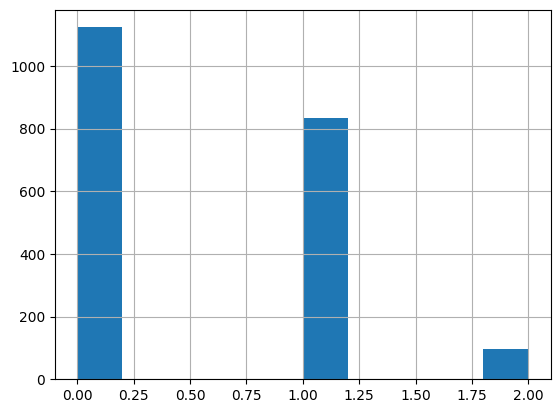

In [14]:
df_mod.label.hist()

In [15]:
df_mod.head()

,Review,label
0,কিছু পৃষ্ঠা ফাঁকা,0
1,প্রত্যাশার নীচে কাগজের গুণমান,0
2,সোলেমানীয়া বুক হাউস প্রকাশনীর সব বই গুলিতে প্র...,0
3,"বইয়ের কাভার আর সূচিপত্র প্রিয়গল্প-২, ভিতরে প্র...",0
4,"কালার , পেজ, লেখার কুয়ালিটি খুবই নিম্ন মানের ,...",0


In [16]:
df_mod.columns = ['sentence','label']
df_mod.to_csv('data.csv',index=None)

In [17]:
from datasets import load_dataset
raw_dataset = load_dataset('csv',data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2053
    })
})

In [19]:
split = raw_dataset['train'].train_test_split(test_size=0.2,seed=42)

In [20]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1642
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 411
    })
})

In [21]:
checkpoint = 'distilbert-base-cased'

In [22]:
from transformers import AutoTokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [24]:
def tokenizer_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [25]:
tokenized_dataset = split.map(tokenizer_fn,batched=True)

Map:   0%|          | 0/1642 [00:00<?, ? examples/s]

Map:   0%|          | 0/411 [00:00<?, ? examples/s]

In [26]:
from transformers import AutoModelForSequenceClassification

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [29]:
!pip install -q torchinfo

In [30]:
!pip install -q transformers[torch]

In [31]:
!pip install -q accelerate -U

In [32]:
import accelerate

In [33]:
accelerate.__version__

'0.21.0'

In [34]:
from torchinfo import summary

In [35]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [36]:
from transformers import Trainer,TrainingArguments

In [37]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy = 'epoch',
    save_strategy='epoch',
    num_train_epochs = 5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [39]:
def compute_metrics(logits_and_labels):
  logits,labels = logits_and_labels
  predictions = np.argmax(logits,axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}

In [40]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [41]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.834011,0.549878,0.364006
2,No log,0.824868,0.542579,0.244909
3,No log,0.772779,0.632603,0.419426
4,No log,0.767001,0.642336,0.429613
5,0.796900,0.760758,0.620438,0.420466


TrainOutput(global_step=515, training_loss=0.7961746178784417, metrics={'train_runtime': 158.767, 'train_samples_per_second': 51.711, 'train_steps_per_second': 3.244, 'total_flos': 375960048446196.0, 'train_loss': 0.7961746178784417, 'epoch': 5.0})

In [42]:
!ls training_dir

checkpoint-103	checkpoint-309	checkpoint-515
checkpoint-206	checkpoint-412	runs


In [43]:
from transformers import pipeline

In [45]:
savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-206',
                      device=0)

In [46]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 411
})

In [47]:
test_pred = savedmodel(split['test']['sentence'])

In [48]:
test_pred

[{'label': 'LABEL_0', 'score': 0.4898233413696289},
 {'label': 'LABEL_0', 'score': 0.7122894525527954},
 {'label': 'LABEL_0', 'score': 0.6758884787559509},
 {'label': 'LABEL_0', 'score': 0.6564986109733582},
 {'label': 'LABEL_0', 'score': 0.7232407331466675},
 {'label': 'LABEL_0', 'score': 0.6754476428031921},
 {'label': 'LABEL_0', 'score': 0.7188001871109009},
 {'label': 'LABEL_0', 'score': 0.7078480124473572},
 {'label': 'LABEL_0', 'score': 0.6551629304885864},
 {'label': 'LABEL_0', 'score': 0.7122894525527954},
 {'label': 'LABEL_0', 'score': 0.6007856130599976},
 {'label': 'LABEL_0', 'score': 0.5644133687019348},
 {'label': 'LABEL_0', 'score': 0.5813767313957214},
 {'label': 'LABEL_0', 'score': 0.5400350689888},
 {'label': 'LABEL_0', 'score': 0.67580646276474},
 {'label': 'LABEL_0', 'score': 0.686650276184082},
 {'label': 'LABEL_0', 'score': 0.5644133687019348},
 {'label': 'LABEL_0', 'score': 0.6395410299301147},
 {'label': 'LABEL_0', 'score': 0.7060194611549377},
 {'label': 'LABEL_

In [49]:
def get_label(d):
  return int(d['label'].split('_')[1])
test_pred = [get_label(d) for  d in test_pred]

In [50]:
print('acc:',accuracy_score(split['test']['label'],test_pred))

acc: 0.5425790754257908


In [51]:
print('f1:',f1_score(split['test']['label'],test_pred,average='macro'))

f1: 0.2449092839220228


In [54]:
def plot_cm(cm):
  classes = ['Publisher','Book','Platform']
  df_cm = pd.DataFrame(cm,index=classes,columns=classes)
  ax = sns.heatmap(df_cm,annot=True,fmt='g')

cm = confusion_matrix(split['test']['label'],test_pred,normalize='true')

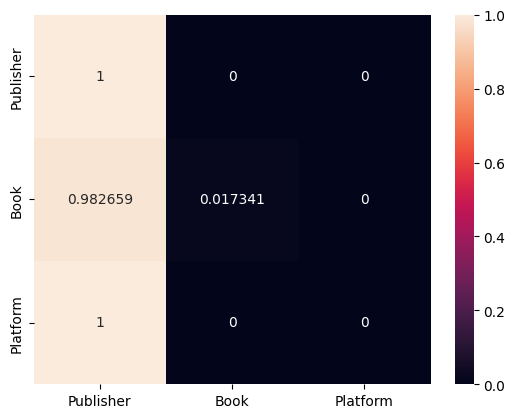

In [55]:
plot_cm(cm)